## MultiViewAtlas demo

In this tutorial we show how to initialize a MultiViewAtlas object from an existing set of `.h5ad` files of different views, and we show the main components of the object.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

import multi_view_atlas as mva

Global seed set to 0
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Load fetal-immune dataset

Files downloaded from https://developmental.cellatlas.io/fetal-immune  

In [3]:
datadir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
h5ad_files = [f for f in os.listdir(datadir) if f.endswith('embedding.h5ad')]
h5ad_files

['PAN.A01.v01.raw_count.20210429.HSC_PROGENITORS.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.MEM_PROGENITORS.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.STROMA.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.MYELOID_V2.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad']

In [4]:
# Load full atlas 
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'), backed=True)

To create a MultiViewAtlas object we need to define the hierarchy between views. This indicates in dictionary format which views are parents of which other views, and which views have no further subsets (`None`). Each view can have only one parent view.

In [6]:
## Define the hierarchy between views 
view_hierarchy = {'full':{
 'HSC_IMMUNE':{
        'HSC_PROGENITORS':None,
        'LYMPHOID':{
            'NKT':None
        },
        'MYELOID_V2':None,
        'MEM_PROGENITORS':None
    },
    'STROMA':None   
    }
}

In [7]:
# Load each view
adata_dict = {}
adata_dict['full'] = adata_full
for v in mva.utils.get_views_from_structure(view_hierarchy):
    if v != 'full':
        vdata = sc.read_h5ad(os.path.join(datadir, f'PAN.A01.v01.raw_count.20210429.{v}.embedding.h5ad'), backed=True)
        # adata_dict[v] = AnnData(obs=vdata.obs, obsm=vdata.obsm)
        adata_dict[v] = vdata

## Initialize MultiViewAtlas object

A MultiViewAtlas object can be initialized from a `MuData` object, storing the view hierarchy in `.uns`, or from an `AnnData` object of the full dataset, additionally storing an assignment of cells to views in `adata.obsm['view_assign']` (here we don't want to initialize from AnnData because for all the views we already have different dimensionality reductions). 

The `transition_rule` parameter defines which info should be used to subset cells from one parent view to a child view. This is used only when new data is mapped to this reference dataset, so it can be set to `None`. The transition rule is set to be the same for all transitions during initialization, but it can be updated later. 

In [8]:
# # Initialize from AnnData
# 
# # make table assigning cells to views
# view_assign = pd.DataFrame(index=adata_full.obs_names)
# for v in adata_dict.keys():
#     view_assign[v] = view_assign.index.isin(adata_dict[v].obs_names).astype(int)
# 
# adata_full.uns['view_hierarchy'] = view_hierarchy.copy()
# adata_full.obsm['view_assign'] = view_assign.copy()
# mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='X_scvi')

# Initialize from mudata object
mdata = mudata.MuData(adata_dict)
mdata.obs = mdata['full'].obs.copy() # otherwise obs cols are named full:colname 
mdata['full'].uns['view_hierarchy'] = view_hierarchy.copy()
mvatlas = mva.tl.MultiViewAtlas(mdata, transition_rule=None)

In [9]:
mvatlas

MultiViewAtlas object with view hierarchy:
	full:
	  HSC_IMMUNE:
	    HSC_PROGENITORS: null
	    LYMPHOID:
	      NKT: null
	    MEM_PROGENITORS: null
	    MYELOID_V2: null
	  STROMA: null
	
MuData object with n_obs × n_vars = 911873 × 268304
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
  obsm:	'view_assign'
  8 modalities
    full:	911873 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'leiden', 'scvi', 'umap', 'view_h

The `MultiViewAtlas` object stores a MuData object where modalities are different subsets (views) of the full dataset. The full gene expression matrix is stored only in the `full` view, while for all other views we store latent dimensions in `.obsm` and metadata in `.obs` only. We can attach gene expression values to a single view when needed accessing directly from the MultiViewAtlas object.

The hierarchy between views is stored in `mvatlas.view_hierarchy`

In [10]:
mvatlas.view_hierarchy

{'full': {'HSC_IMMUNE': {'HSC_PROGENITORS': None,
   'LYMPHOID': {'NKT': None},
   'MYELOID_V2': None,
   'MEM_PROGENITORS': None},
  'STROMA': None}}

The information used to transition from one parent view to a child view is stored in `mvatlas.view_transition_rule`. The transition rule can be a latent space (a slot in `.obsm`) or cell-level metadata (a column in `.obs`). If the transition rule is a latent space, cells in one view are assigned to the next view by similarity in that latent space. If the transition rule is cell-level metadata, cells in one view are assigned to the next view based on labels for that column in obs.

In [11]:
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NKT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can set different rules for different transitions. For example we can set the split from Lymphoid to NKT view to be based on annotation labels, rather than position in the latent space (__N.B. for now I haven't implemented any check that the rule is followed, if the atlas is already initialized!__)

In [12]:
mvatlas.set_transition_rule(parent_view='LYMPHOID', child_view='NKT', transition_rule='anno_lvl_2_final_clean')
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN
NKT,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize multi-view structure

The `multiview_embedding` plot shows the embedding of cells in a view and highlighting those cells in all the parent views.

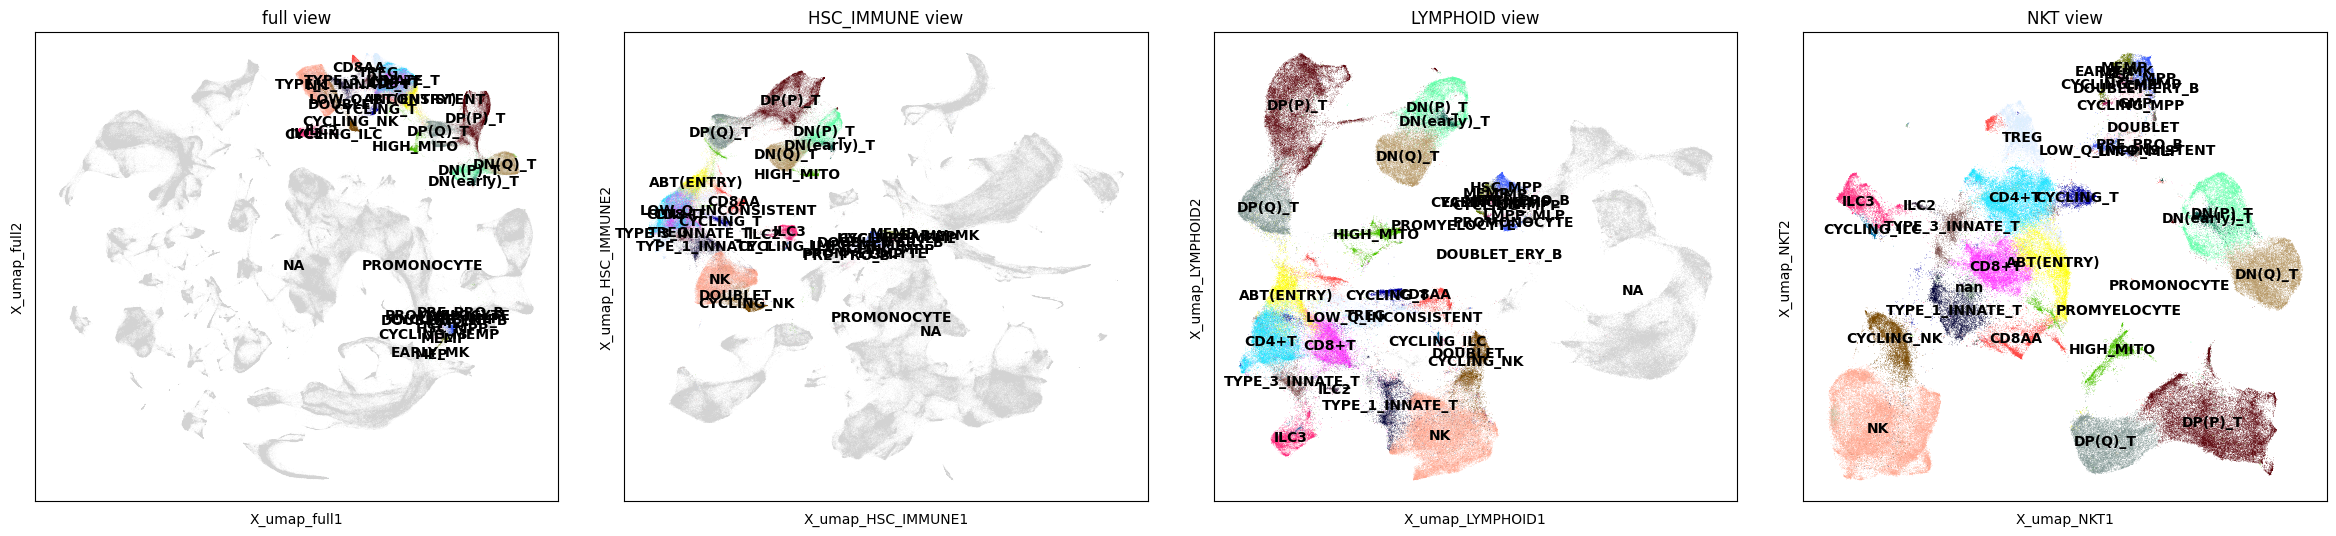

In [13]:
mva.pl.multiview_embedding(mvatlas.mdata, view='NKT', color='anno_lvl_2_final_clean')

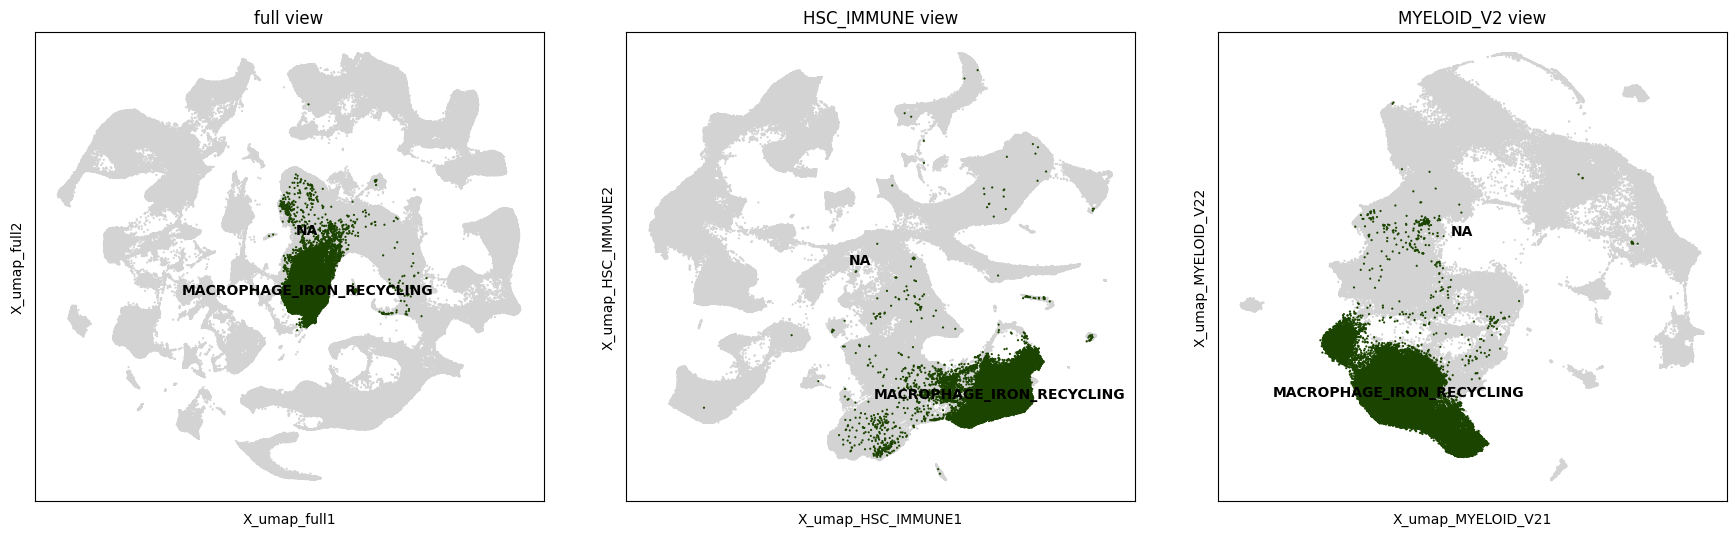

In [14]:
mva.pl.multiview_embedding(mvatlas.mdata, view='MYELOID_V2', color='anno_lvl_2_final_clean', groups=['MACROPHAGE_IRON_RECYCLING'], size=10)


The `view_hierarchy` plot can be used to visualize the structure between views, showing the proportion and number of cells in each view.

In [15]:
# import multi_view_atlas as mva

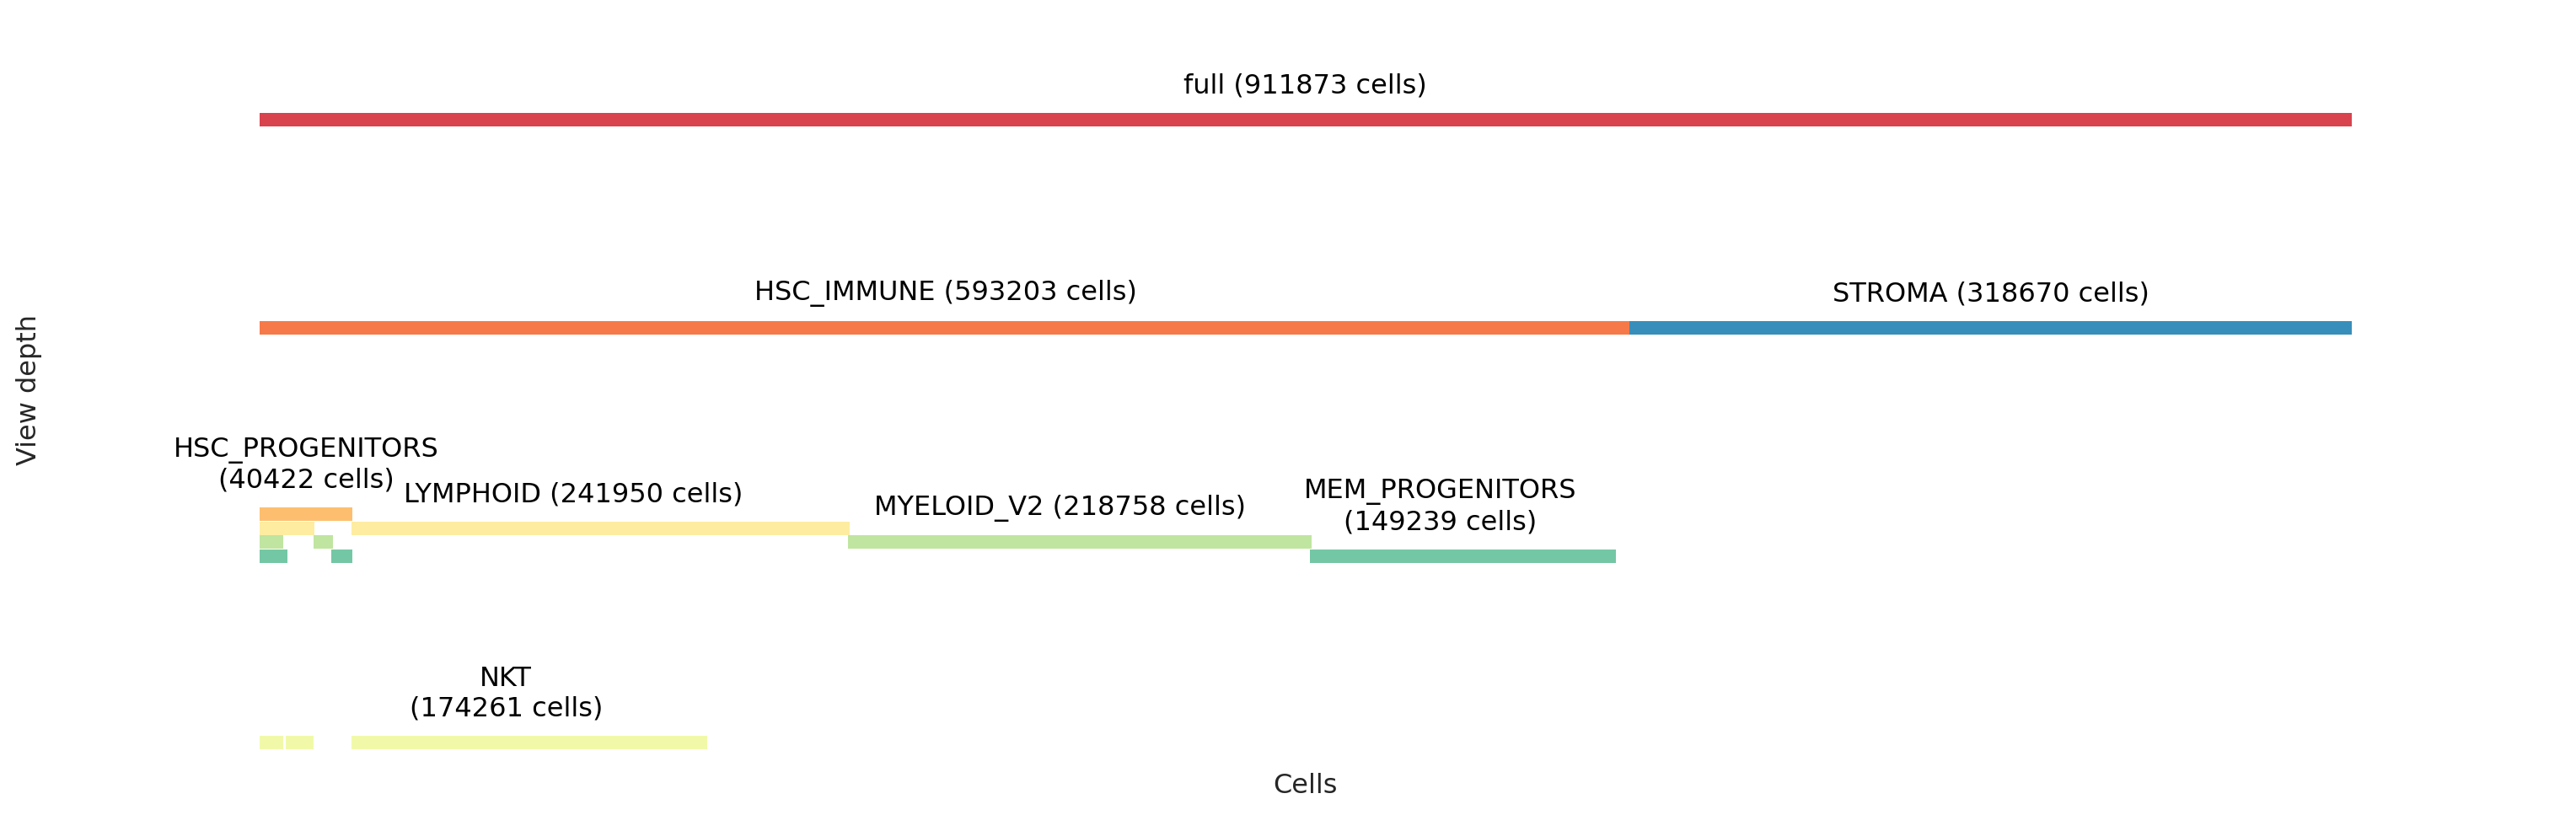

In [16]:
mva.pl.view_hierarchy(
    mvatlas, 
    subsample_fraction=0.01, ## Shows only a fraction of cells for faster plotting (but proportions are maintained)
    figsize = (20, 6),
    color = 'Spectral'
)

Visualize views for a subset of cells

In [17]:
thymus_cells = mvatlas.mdata.obs_names[mvatlas.mdata.obs['organ'] == 'TH']

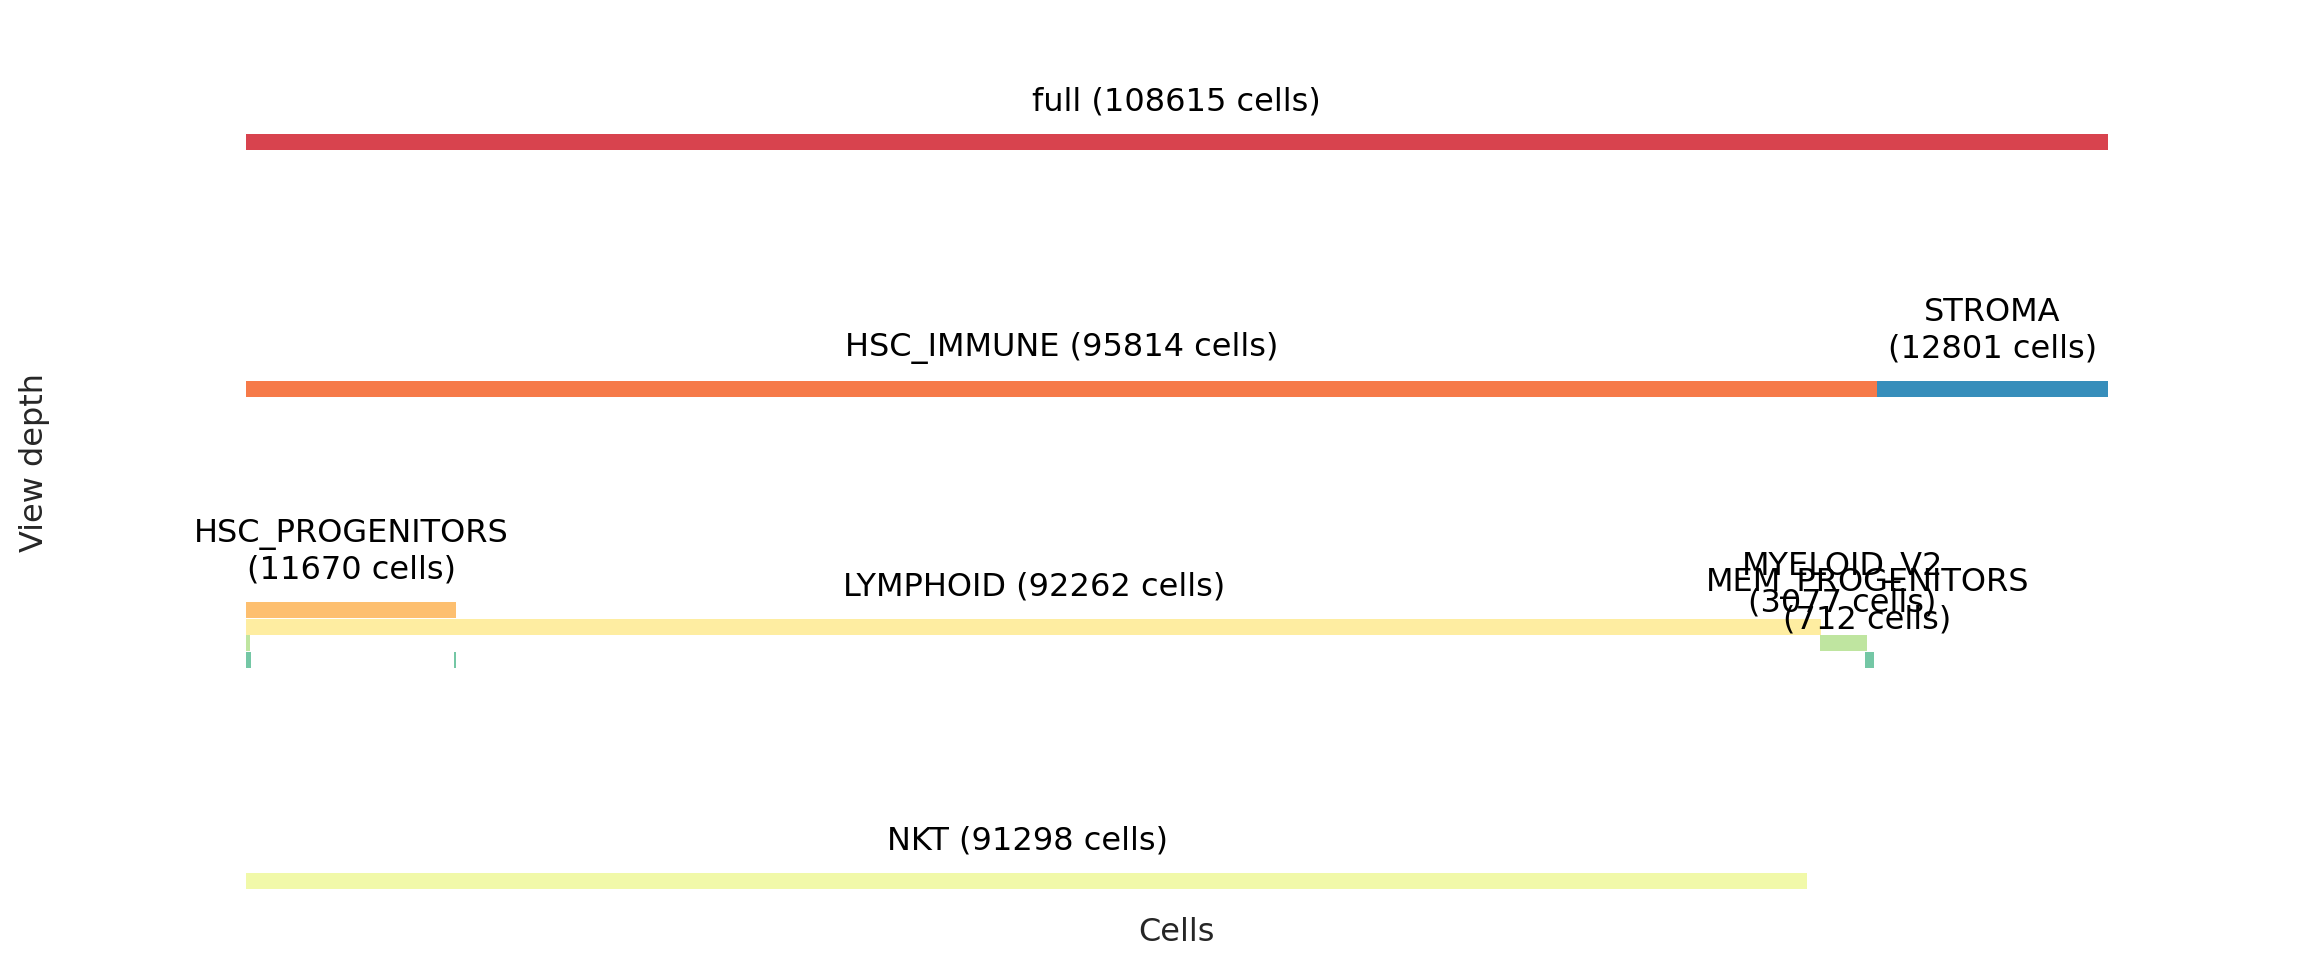

In [18]:
mva.pl.view_hierarchy(
    mvatlas, 
    subset_obs = thymus_cells,
    subsample_fraction=0.05, 
    figsize = (15, 6),
    color = 'Spectral'
)

## Add new views to atlas 

We can add new splits to a MultiViewAtlas object as we go, making a new assignment table. For example, we might want to split the stromal compartment by organ classes.

In [13]:
assign_dict = {
    'hematopoietic_tissue':['BM', "LI", "YS"],
    'lymphoid_tissue':['TH', "MLN", "SP"],
    'peripheral_tissue':['SK', "GU", 'KI']
}

transition_rule = 'organ'
parent_view = 'STROMA'

assign_tab = np.vstack([np.where(mvatlas.mdata[parent_view].obs[transition_rule].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = mvatlas.mdata[parent_view].obs_names)

In [14]:
assign_tab.head()

,hematopoietic_tissue,lymphoid_tissue,peripheral_tissue
index,,,
FCAImmP7579224-GGGTTGCAGAAGGGTA,0,0,1
FCAImmP7579224-GACTGCGTCTTGGGTA,0,0,1
FCAImmP7579224-ATCATGGTCAAGAAGT,0,0,1
FCAImmP7579224-ACGGCCACACAACTGT,0,0,1
FCAImmP7579224-GAAACTCAGGCTCATT,0,0,1


In [15]:
mvatlas.update_views(parent_view='STROMA', child_assign_tab=assign_tab, transition_rule=transition_rule)

In [16]:
mvatlas.mdata['hematopoietic_tissue']

AnnData object with n_obs × n_vars = 38505 × 0
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
    obsm: 'X_scvi_full', 'X_umap_full', 'view_assign_full'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [17]:
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA,hematopoietic_tissue,lymphoid_tissue,peripheral_tissue
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN,NaN,NaN,NaN
NKT,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,organ,organ,organ
hematopoietic_tissue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,organ,NaN,NaN
lymphoid_tissue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,NaN,organ,NaN


In [18]:
mvatlas.mdata['lymphoid_tissue'].obs['organ'].value_counts()


SP     46754
TH     12801
MLN      623
Name: organ, dtype: int64

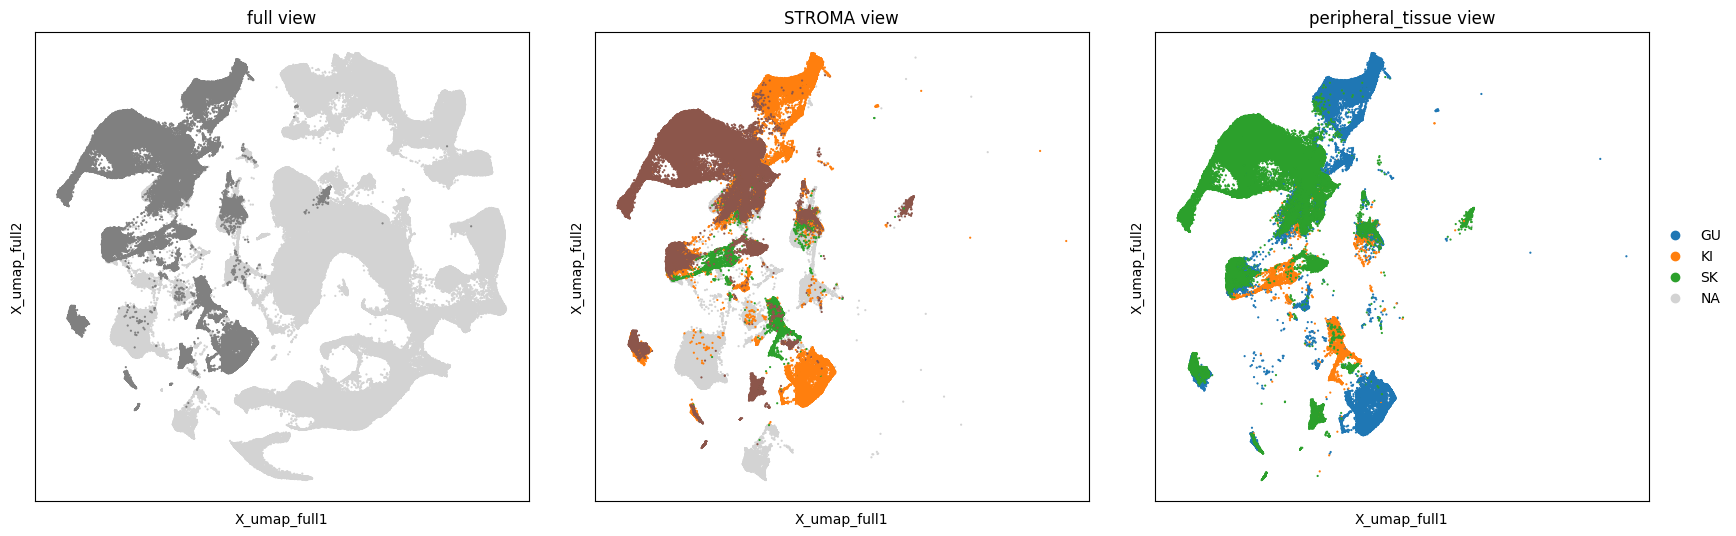

In [21]:
mva.pl.multiview_embedding(mvatlas.mdata, view='peripheral_tissue', 
                           color='organ', basis_from_full=True, basis='X_umap_full',
                           legend_loc='right margin', size=10)

## Session info

In [19]:
import session_info
session_info.show()

---
---